In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import ast
from scipy.stats import uniform, randint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

In [6]:
wine_pd = pd.read_csv('winemag-data-130k-v2.csv')

In [7]:
wine_pd.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## EDA

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Step 1: Sample a subset of the data
wine_subset = wine_pd.sample(frac=0.1, random_state=42)  # Adjust fraction as needed

# Step 2: Preprocess the data
selected_features = ['country', 'province', 'variety', 'winery', 'points']
wine_subset = wine_subset[selected_features]

# Adding encoding to the categorical columns for improving analysis
categorical_cols = ['country', 'province', 'variety', 'winery']
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_cols = pd.DataFrame(encoder.fit_transform(wine_subset[categorical_cols]))
encoded_cols.index = wine_subset.index
wine_encoded = pd.concat([wine_subset.drop(categorical_cols, axis=1), encoded_cols], axis=1)

# Step 3: Split the data into training and testing sets
X = wine_encoded.drop('points', axis=1)
y = wine_encoded['points']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/Users/zhanmingxiao/miniconda3/envs/509/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


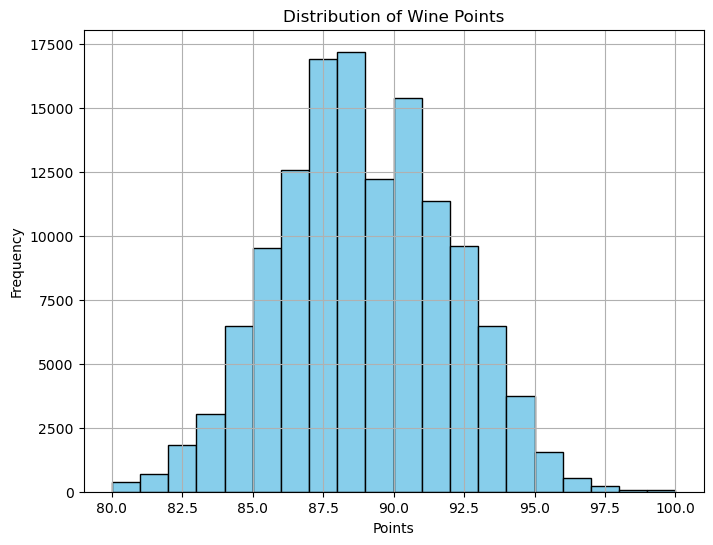

In [9]:
import matplotlib.pyplot as plt

# Plotting histogram for points column to check the distribution
plt.figure(figsize=(8, 6))
plt.hist(wine_pd['points'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Wine Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### The points column, which we aim to predict, ranges from 80 to 100, with a mean score of approximately 88.44. The distribution of wine points is fairly normal, indicating a good range of quality scores in the dataset.
#### There are missing values in several columns, notably in designation, price, region_1, region_2, taster_name, and taster_twitter_handle. However, for the purpose of predicting wine quality (points), we may not need all these features.
#### The price column, which we will avoid for our analysis might not be a significant predictor of wine quality and it also has 8,996 missing values. Hence, it does not really bring any significant value which is why we exclude it from our analysis.

## Decreasing Dimensionality of the dataset

In [10]:
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define the columns to apply PCA on (categorical columns)
categorical_cols = [0, 1, 2, 3]  # Assuming the categorical columns are the first four columns

# Define a pipeline for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', [4]),  # Pass through points column as it is numerical (assuming it's the 5th column)
        ('cat', OneHotEncoder(), categorical_cols)  # One-hot encode categorical columns
    ])

# Create a pipeline with preprocessing and PCA
pca_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95))  # Preserve 95% of variance
])

# Fit and transform the training set
X_train_pca = pca_pipe.fit_transform(X_train_scaled)

# Transform the test set (using the parameters learned from training set)
X_test_pca = pca_pipe.transform(X_test_scaled)

# Print the shape of the transformed data
print("Shape of X_train after PCA:", X_train_pca.shape)
print("Shape of X_test after PCA:", X_test_pca.shape)


Shape of X_train after PCA: (10397, 3)
Shape of X_test after PCA: (2600, 3)


## Regression models

In [11]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

# Train Linear Regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train_pca, y_train)

# Train Ridge Regression model
ridge_reg = Ridge(alpha=1.0)  # You can adjust the regularization strength (alpha) as needed
ridge_reg.fit(X_train_pca, y_train)

# Train Lasso Regression model
lasso_reg = Lasso(alpha=1.0)  # You can adjust the regularization strength (alpha) as needed
lasso_reg.fit(X_train_pca, y_train)

# Evaluate models using RMSE
def calculate_rmse(model, X, y):
    y_pred = model.predict(X)
    rmse = mean_squared_error(y, y_pred, squared=False)
    return rmse

linear_rmse = calculate_rmse(linear_reg, X_test_pca, y_test)
ridge_rmse = calculate_rmse(ridge_reg, X_test_pca, y_test)
lasso_rmse = calculate_rmse(lasso_reg, X_test_pca, y_test)

# Print RMSE for each model
print("Linear Regression RMSE:", linear_rmse)
print("Ridge Regression RMSE:", ridge_rmse)
print("Lasso Regression RMSE:", lasso_rmse)

# Select the best-performing model
best_model = min(linear_rmse, ridge_rmse, lasso_rmse)
if best_model == linear_rmse:
    print("Linear Regression is the best-performing model.")
elif best_model == ridge_rmse:
    print("Ridge Regression is the best-performing model.")
else:
    print("Lasso Regression is the best-performing model.")

Linear Regression RMSE: 3.099584028196865
Ridge Regression RMSE: 3.099578732245382
Lasso Regression RMSE: 3.1171824440162603
Ridge Regression is the best-performing model.


In [12]:
from sklearn.metrics import r2_score
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Train a Linear Regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = linear_reg.predict(X_test_scaled)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)

# Calculate adjusted R-squared
n = len(y_test)
p = X_test_scaled.shape[1]  # Number of predictors/features
adjusted_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - p - 1))
print("Adjusted R-squared:", adjusted_r_squared)

R-squared: -6.456290617914828e+26
Adjusted R-squared: 3.682224998016379e+26


#### High multicollinearity among predictors can inflate R-squared values, making it challenging to discern the true contributions of individual predictors to the target variable. This can occur when predictors are highly correlated with each other, leading to unstable estimates of regression coefficients.

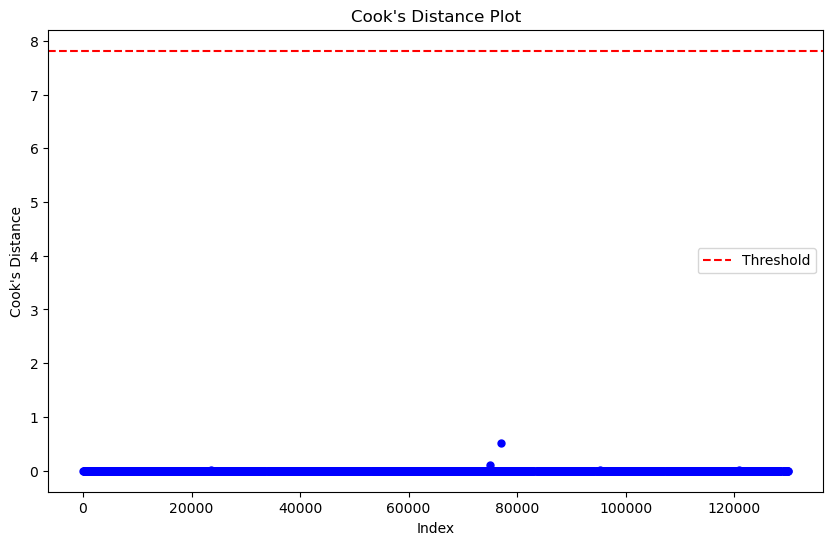

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2

# Calculate residuals
residuals = y_test - y_pred

# Calculate leverage
n, p = X_test_pca.shape
H = np.dot(X_test_pca, np.dot(np.linalg.inv(np.dot(X_train_pca.T, X_train_pca)), X_test_pca.T))
leverage = np.diagonal(H)

# Compute Cook's distance
mse = mean_squared_error(y_test, y_pred)
cooks_d = (residuals**2 / mse) * leverage / (p * (1 - leverage))

# Calculate the critical value for Cook's distance (threshold)
alpha = 0.05  # significance level
threshold = chi2.ppf(1 - alpha, p)

# Plot Cook's distance
plt.figure(figsize=(10, 6))
plt.plot(cooks_d, 'bo', markersize=5)
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance Plot")
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()